# Imports

In [1]:
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
import pandas as pd
import os
from os import listdir
from os.path import isfile, join

import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

# Load datasets

In [2]:
datasets = list()
DATA_DIR = "../datasets/data"
TABULAR_SEP_FIX =  ["204", "205", "206", "207", "208", "225", "226", "242", "243"]

for dataset_filename in listdir(DATA_DIR):
    # 012_UCR_Anomaly_tiltAPB1_100000_114283_114350.txt
    # [0] [1] [2]     [3]      [4]    [5]    [6]   .txt
    split = dataset_filename.replace(".txt", "").split("_")
    
    dataset = {
        "number": split[0],
        "name": split[3],
        "train_end_idx": int(split[4]),
        "anomaly_start_idx": int(split[5]) - int(split[4]),
        "anomaly_end_idx": int(split[6]) - int(split[4]),
        "path": join(DATA_DIR, dataset_filename),
        "separator": "\n" if split[0] not in TABULAR_SEP_FIX else "  "
    }
    
    datasets.append(dataset)

In [3]:
datasets[9]

{'number': '206',
 'name': 'CHARISten',
 'train_end_idx': 25130,
 'anomaly_start_idx': 3950,
 'anomaly_end_idx': 4010,
 'path': '../datasets/data/206_UCR_Anomaly_CHARISten_25130_29080_29140.txt',
 'separator': '  '}

In [4]:
def load_dataset(dataset):
    with open(dataset["path"]) as file:
        data_ = [float(x) for x in filter(None, file.read().split(dataset["separator"]))]
    return data_

In [5]:
for i in range(len(datasets)):
    data = load_dataset(datasets[i])
    datasets[i]["train"] = pd.Series(data[:datasets[i]["train_end_idx"]])
    datasets[i]["test"] = pd.Series(data[datasets[i]["train_end_idx"]:])

In [6]:
datasets[9]

{'number': '206',
 'name': 'CHARISten',
 'train_end_idx': 25130,
 'anomaly_start_idx': 3950,
 'anomaly_end_idx': 4010,
 'path': '../datasets/data/206_UCR_Anomaly_CHARISten_25130_29080_29140.txt',
 'separator': '  ',
 'train': 0        7716.0
 1        7573.0
 2        7409.0
 3        7298.0
 4        7139.0
           ...  
 25125      58.0
 25126      58.0
 25127      63.0
 25128      55.0
 25129      62.0
 Length: 25130, dtype: float64,
 'test': 0          67.0
 1          59.0
 2          63.0
 3          46.0
 4          65.0
           ...  
 16865    8287.0
 16866    8202.0
 16867    8075.0
 16868    7880.0
 16869    7729.0
 Length: 16870, dtype: float64}

In [7]:
def plot_dataset(dataset, figsize=(20,6)):
    d = dataset
    fig, axs = plt.subplots(1, 2, figsize=figsize)
    
    fig.suptitle("Number: {} \n Name: {}".format(d["number"], d["name"]))
    
    # Plot test + train
    offset1 = np.array(range(len(d["test"]))) + len(d["train"])
    offset2 = np.array(range(d["anomaly_end_idx"] - d["anomaly_start_idx"])) + len(d["train"]) + d["anomaly_start_idx"]
    
    axs[0].plot(d["train"], color="palegreen")
    axs[0].plot(offset1, d["test"], color="skyblue")
    axs[0].plot(offset2, d["test"][d["anomaly_start_idx"]:d["anomaly_end_idx"]], color="red")
    
    axs[0].legend(["Train", "Test", "Anomaly"])
    
    # Show anonmaly
    
    
    offset3 = np.array(range(len(d["test"])+1000))
    
    axs[1].plot(d["test"][(d["anomaly_start_idx"]-1000):(d["anomaly_end_idx"]+1000)], color="lightblue")
    axs[1].plot(d["test"][(d["anomaly_start_idx"]):(d["anomaly_end_idx"])], color="red")
    

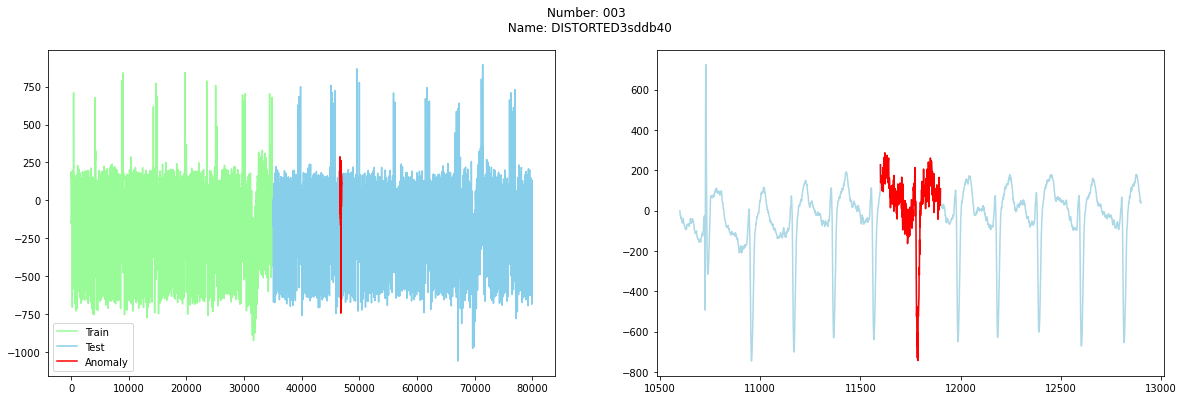

In [8]:
plot_dataset(datasets[0])

# Detecting anomalies

In [18]:
BATCH_SIZE = 1000
EPOCHS = 30
WINDOW_SIZE = 25
NMETRICS = 1
HIDDEN_SIZE = 10

In [19]:
from src.model import USADModel
from src.preprocessing import featurize, get_dataloader

In [20]:
import torch
from pytorch_lightning import Trainer

In [21]:
train, test = datasets[0]['train'], datasets[0]['test'] 

In [22]:
len(train), len(test)

(35000, 45000)

In [23]:
train, test = featurize(train.values, test.values, WINDOW_SIZE)

In [24]:
len(train), len(test)

(34975, 44975)

In [25]:
dl_train, dl_test = get_dataloader(train, BATCH_SIZE), get_dataloader(test, BATCH_SIZE)

In [26]:
model = USADModel(window_size=WINDOW_SIZE * NMETRICS, z_size=WINDOW_SIZE * HIDDEN_SIZE)
trainer = Trainer(gpus=1, max_epochs=EPOCHS, )
trainer.fit(model, dl_train, dl_train)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type    | Params
--------------------------------------
0 | encoder   | Encoder | 2.1 K 
1 | decoder_1 | Decoder | 1.9 K 
2 | decoder_2 | Decoder | 1.9 K 
--------------------------------------
6.0 K     Trainable params
0         Non-trainable params
6.0 K     Total params
0.024     Total estimated model params size (MB)


/home/pk/miniconda3/envs/usad-on-ucr-data/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:105: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/pk/miniconda3/envs/usad-on-ucr-data/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:105: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/pk/miniconda3/envs/usad-on-ucr-data/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:326: UserWarning: The number of training samples (35) is smaller than the logging interval

Epoch 0:  50%|████████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 35/70 [00:00<00:00, 62.52it/s, loss=1.28, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 1:  50%|████████████████████████████████████████████████████████████████████████████████████                                                                                    | 35/70 [00:00<00:00, 67.33it/s, loss=0.626, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 2:  50%|████████████████████████████████████████████████████████████████████████████████████                                                                                    | 35/70 [00:00<00:00, 74.14it/s, loss=0.401, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 3:  50%|████████████████████████████████████████████████████████████████████████████████████                                                                                    | 35/70 [00:00<00

In [27]:
y_pred = trainer.predict(model, dl_test)
y_pred = np.concatenate([torch.stack(y_pred[:-1]).flatten().detach().cpu().numpy(),
                         y_pred[-1].flatten().detach().cpu().numpy()])

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/pk/miniconda3/envs/usad-on-ucr-data/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:105: UserWarning: The dataloader, predict dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 59.86it/s]


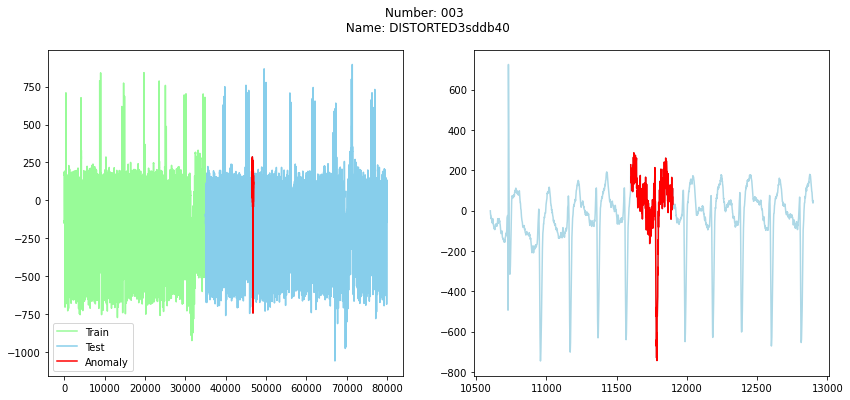

In [67]:
plot_dataset(datasets[0], figsize=(14,6))

In [62]:
def plot_dataset_with_pred(dataset,y=None,  figsize=(20,10)):
    d = dataset
    fig = plt.figure(figsize=figsize)
    
    gs = fig.add_gridspec(2, 2)
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[0, 1])
    ax3 = fig.add_subplot(gs[1, :])
    
    fig.suptitle("Number: {} \n Name: {}".format(d["number"], d["name"]))
    
    #fig2, axs2 = axs.subplots(2,1)
    # Plot test + train
    offset1 = np.array(range(len(d["test"]))) + len(d["train"])
    offset2 = np.array(range(d["anomaly_end_idx"] - d["anomaly_start_idx"])) + len(d["train"]) + d["anomaly_start_idx"]
    
    ax1.plot(d["train"], color="palegreen")
    ax1.plot(offset1, d["test"], color="skyblue")
    ax1.plot(offset2, d["test"][d["anomaly_start_idx"]:d["anomaly_end_idx"]], color="red")
    
    ax1.legend(["Train", "Test", "Anomaly"])
    
    # Show anonmaly
    offset3 = np.array(range(len(d["test"])+1000))
    
    ax2.plot(d["test"][(d["anomaly_start_idx"]-1000):(d["anomaly_end_idx"]+1000)], color="lightblue")
    ax2.plot(d["test"][(d["anomaly_start_idx"]):(d["anomaly_end_idx"])], color="red")
    ax2.set_title("Anomaly")
    ax2.legend(["Test", "Anomaly"])
    
    # Plot prediction score
    ax3.set_title("Reconstruction error on test data")
    ax3.plot(d["test"], color="skyblue")
    offset4 = np.array(range(d["anomaly_end_idx"]-(d["anomaly_start_idx"]))) + d["anomaly_start_idx"]
    ax3.plot(offset4,d["test"][(d["anomaly_start_idx"]):(d["anomaly_end_idx"])], color="red")
    ax3.legend(["test", "anomaly"])
    if y is not None:
        ax4 = ax3.twinx()
        ax4.plot(y, color="orange")
        ax4.legend(["recostruction error"], loc=2)
        
    

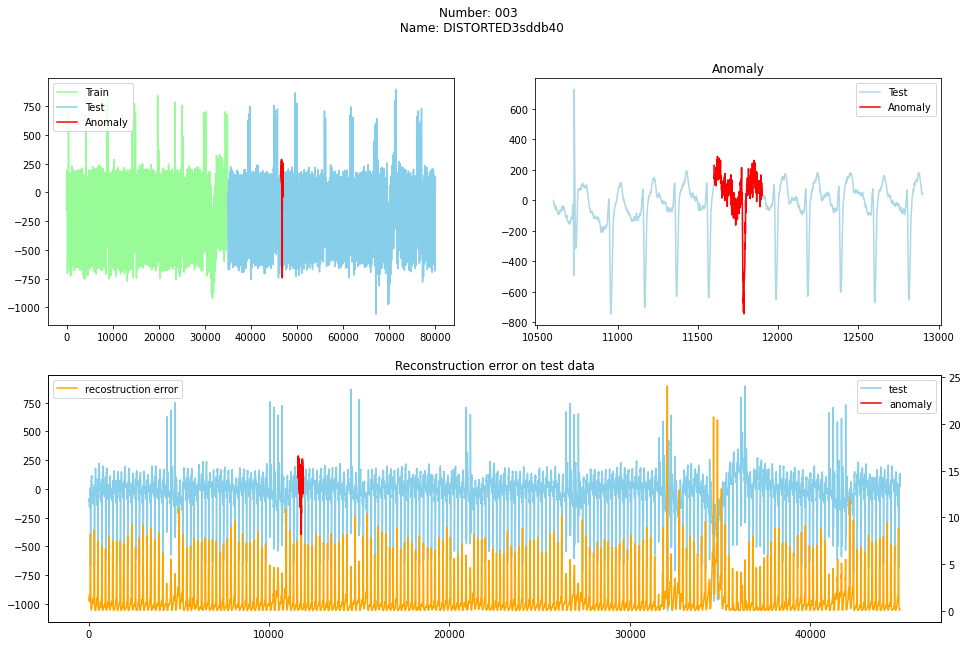

In [68]:
plot_dataset_with_pred(datasets[0],y_pred, figsize=(16,10))

In [82]:
len(datasets[0]["train"])

35000

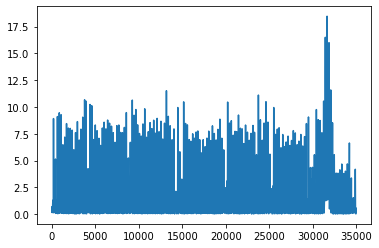

In [32]:
plt.plot(y_pred)